In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv("/home/martinez/git/ms2020bgd/SD701/airbnb/airbnb_paris2.csv", delimiter=',')
sns.set()
plt.rcParams['figure.figsize'] = [20, 12]

/home/martinez/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# SD701 - Prédiction d'un modèle

## Données : Airbnb
J'ai choisi d'utiliser une extraction de la base d'Airbnb pour la ville de Paris. Cette base se trouve à l'adresse suivante:
http://insideairbnb.com/paris/#

Ce n'est pas une base officielle d'Airbnb, mais une extraction plus ou moins fidèle des données.

Ma problématique est la suivante: à partir des données d'une annonce, est ce que je peux estimer la note que les utilisateurs lui donneront?

Pour cela, j'ai commencé par regarder les champs de la base, et notament les notes. Il y a 7 champs; 6 entre 1 et 10 en valeur entière, un entre 1 et 100.

In [14]:
df.shape
df = df[df.number_of_reviews!=0]
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Mean Score
0,3109,https://www.airbnb.com/rooms/3109,20190916233617,2019-09-18,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,none,Good restaurants very close the Montparnasse S...,...,f,flexible,f,f,1,1,0,0,0.24,100.000000
1,5396,https://www.airbnb.com/rooms/5396,20190916233617,2019-09-18,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","Small, well appointed studio apartment at the ...","Cozy, well-appointed and graciously designed s...",none,"You are within walking distance to the Louvre,...",...,f,strict_14_with_grace_period,f,f,1,1,0,0,1.51,88.571429
2,7397,https://www.airbnb.com/rooms/7397,20190916233617,2019-09-17,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !",PLEASE ASK ME BEFORE TO MAKE A REQUEST !!! No ...,"VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...",none,NaN,...,f,moderate,f,f,1,1,0,0,2.45,97.714286
3,7964,https://www.airbnb.com/rooms/7964,20190916233617,2019-09-18,Large & sunny flat with balcony !,Very large & nice apartment all for you! - Su...,hello ! We have a great 75 square meter apartm...,Very large & nice apartment all for you! - Su...,none,NaN,...,f,strict_14_with_grace_period,f,f,1,1,0,0,0.05,99.428571
6,9952,https://www.airbnb.com/rooms/9952,20190916233617,2019-09-17,Paris petit coin douillet,NaN,Make your stay in Paris a perfect experience. ...,Make your stay in Paris a perfect experience. ...,none,NaN,...,f,strict_14_with_grace_period,f,f,1,1,0,0,0.25,99.714286


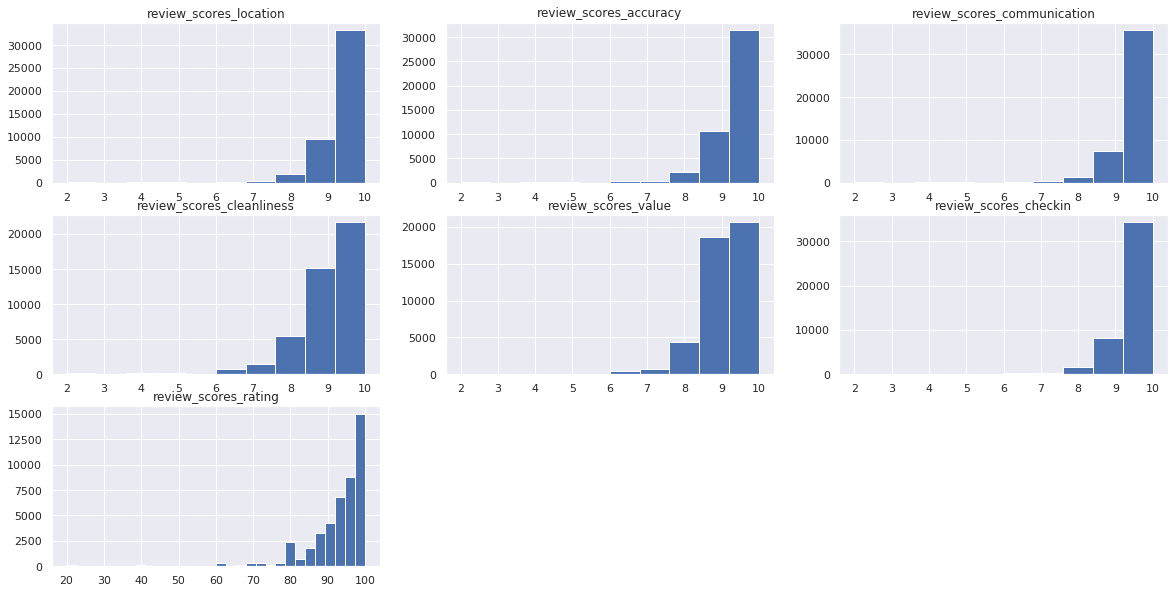

In [15]:
df_score = df[["review_scores_location", "review_scores_accuracy","review_scores_communication","review_scores_cleanliness","review_scores_value","review_scores_checkin","review_scores_rating"]]

df_score = df_score.dropna() # On retire toutes les valeurs nan. Les scores sont homogènes

for i,c in enumerate(df_score.columns):
    plt.subplot(3, 3, i+1)
    if c == "review_scores_rating":
        plt.hist(df_score[c], bins=30)
    else:
        plt.hist(df_score[c], bins=10)
    plt.title(c)
plt.show()

    
    


Afin de lisser les valeurs, j'ai calculé une valeur moyenne de l'ensemble des scores.
Les valeurs de scores nulles sont retirés du dataset afin de garder une moyenne homogène.


92.71428571428571


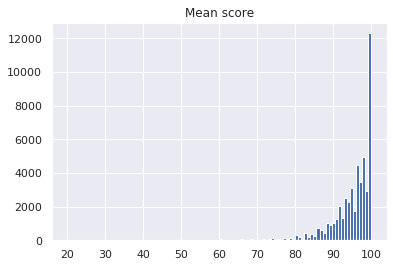

In [4]:
df = df.dropna(subset=df_score.columns)


df["Mean Score"] = 10*(df["review_scores_rating"]/10+df["review_scores_location"]+ \
                             df["review_scores_accuracy"] + df["review_scores_communication"]+df["review_scores_cleanliness"] +df["review_scores_value"] +\
                             df["review_scores_checkin"])/7.0


plt.hist(df["Mean Score"], bins=100)
plt.title("Mean score")

q95 = np.percentile(df["Mean Score"], 25)
print(q95)

Pour faire la prédiction sur les prix, j'ai regardé les colonnes de prix par semaine. C'est une donnée facilement calculable à partir d'un prix journalier si la donnée n'existe pas.


In [5]:
df["price"] = df["price"].str.replace("$","")
df["price"] = df["price"].str.replace(",","")
df.price = pd.to_numeric(df.price)
df.weekly_price = pd.to_numeric(df.weekly_price.str.replace("$","").str.replace(",",""))
mask = df.weekly_price.isnull()
df.loc[mask, "weekly_price"] = df[mask].price*7

Text(0.5, 1.0, 'Histogramme de répartition des prix')

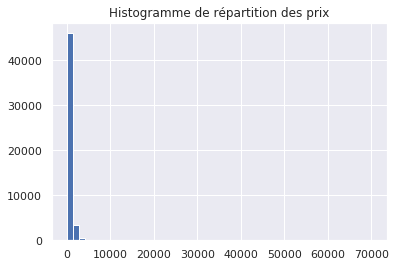

In [6]:
plt.hist(df["weekly_price"] , bins=50, density=False)
plt.title("Histogramme de répartition des prix")

On voit clairement un problème de distribution de valeur. Il exite des valeurs hautes qui pose un gros problème.
On va donc faire un crop des valeurs et on va garder les quantiles 5% et 95%.


In [7]:


#df = df[["weekly_price"]]
#df = df.dropna()

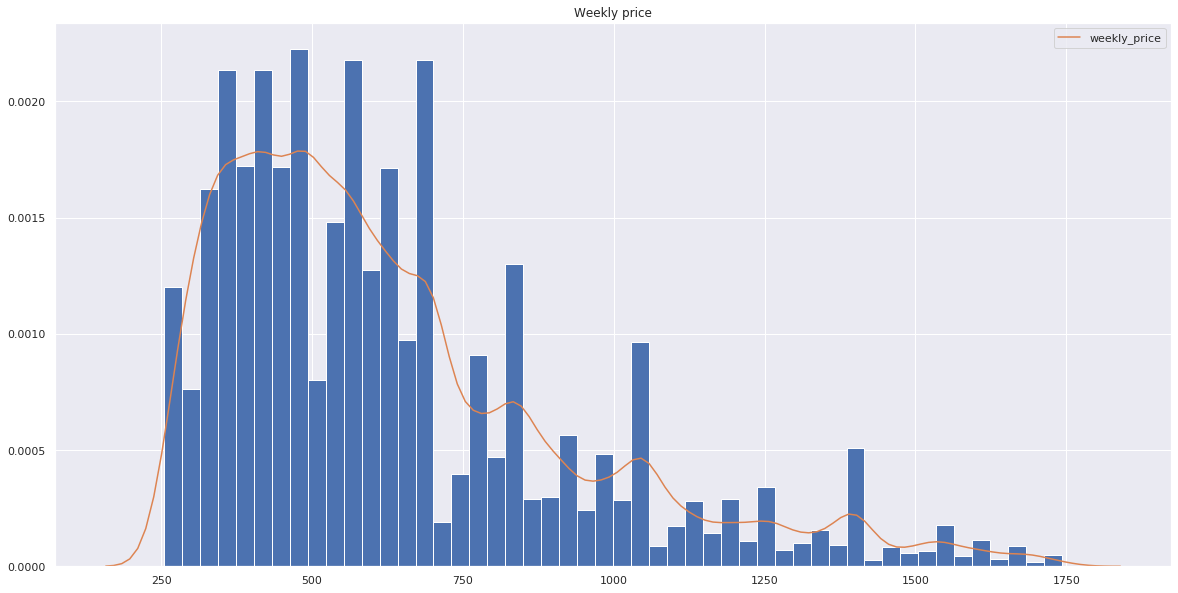

In [8]:

sns.set()
q5 = df["weekly_price"].quantile(0.05)
q95 = df["weekly_price"].quantile(0.95)
df = df[(df.weekly_price > q5) &(df.weekly_price < q95) ]
plt.rcParams['figure.figsize'] = [20, 10]

plt.hist(df["weekly_price"] , bins=50, density=True)
plt.title("Weekly price")
sns.kdeplot(df["weekly_price"] )
plt.show()

Apres ce netoyage, nous avons les scores comme suivants:

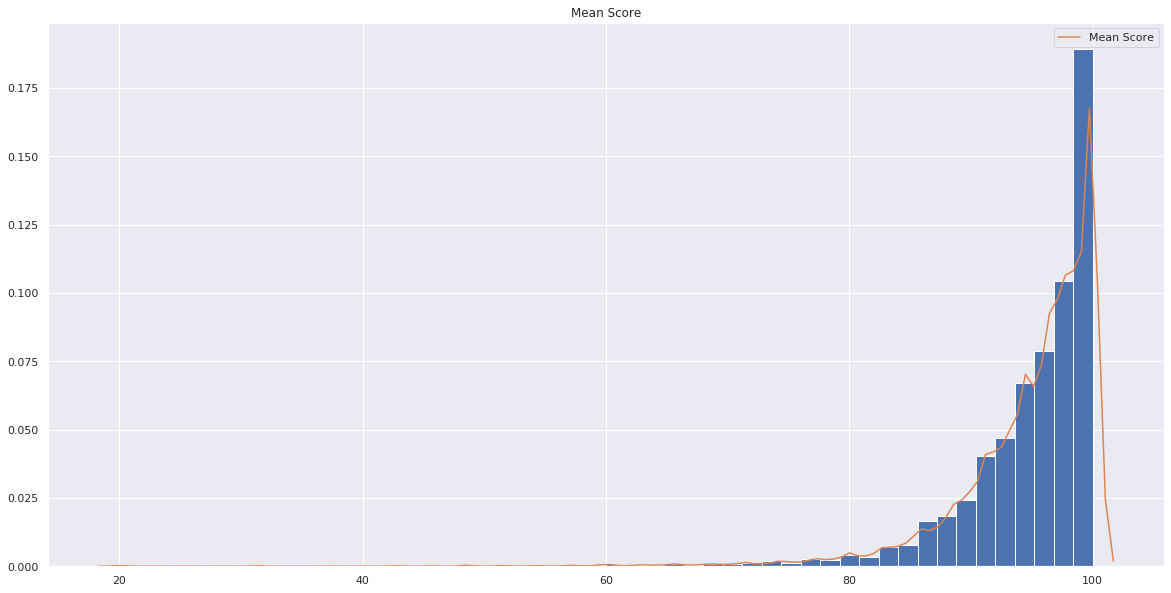

In [9]:
plt.hist(df["Mean Score"] , bins=50, density=True)
plt.title("Mean Score")
sns.kdeplot(df["Mean Score"] )

Pour les autres variables du modèle, nous analyserons les champs:
    - "accommodates", "bathrooms", "guests_included", "bedrooms", "beds", "number_of_reviews","cleaning_fee" comme variables directes
    - "property_type", "room_type", "neighbourhood" en variables catégorielles. Elles sont remises sous forme d'un ensemble de colonne correspondant à chacune des catégories 
    - "amenities" comme variables catégorielles. La récupération de ces valeurs a necessité la création de fonction spécifique (voir le code scala)
    - Une concatenation de l'ensemble des champs texte de la base ("name", "summary", "space", "description", "neighborhood_overview") pour utilisation d'une méthode de parsing type TF-IDF
 
 Nous analysons les variables directes du modèle via une matrice de corrélation.

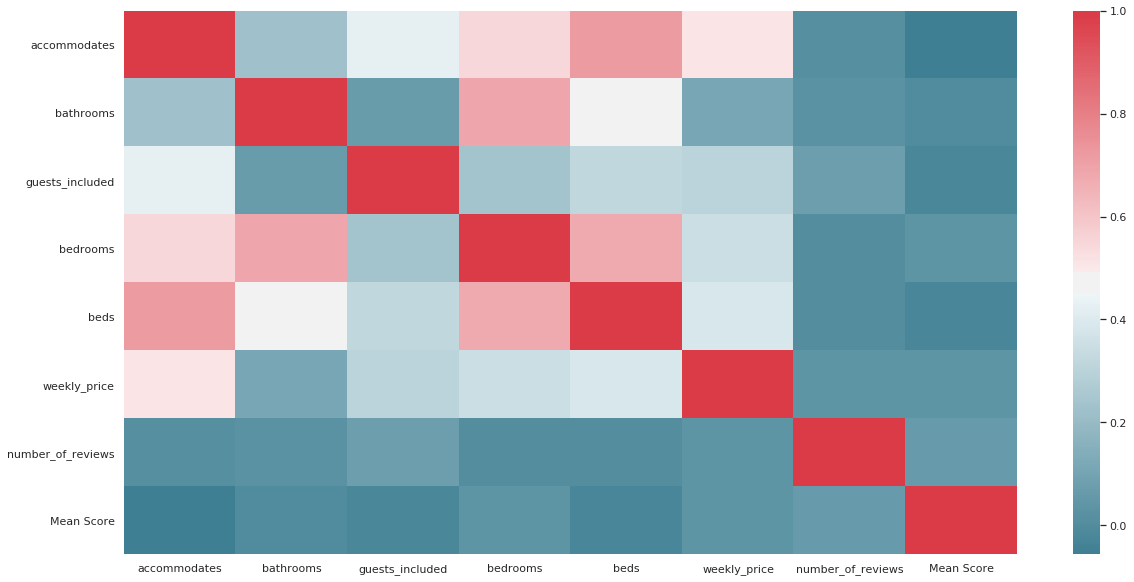

In [10]:
df2 = df[["accommodates", 
    "bathrooms", "guests_included", "bedrooms", "beds", 
    "weekly_price",
    "number_of_reviews",
    "cleaning_fee", "Mean Score"]]

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df2.corr(), cmap=cmap)

Nous filtrons aussi nos données sur les données qui ont au moins une revue. Le nombre de reviewer n'ai par contre pas utilisé lors de nos regressions.

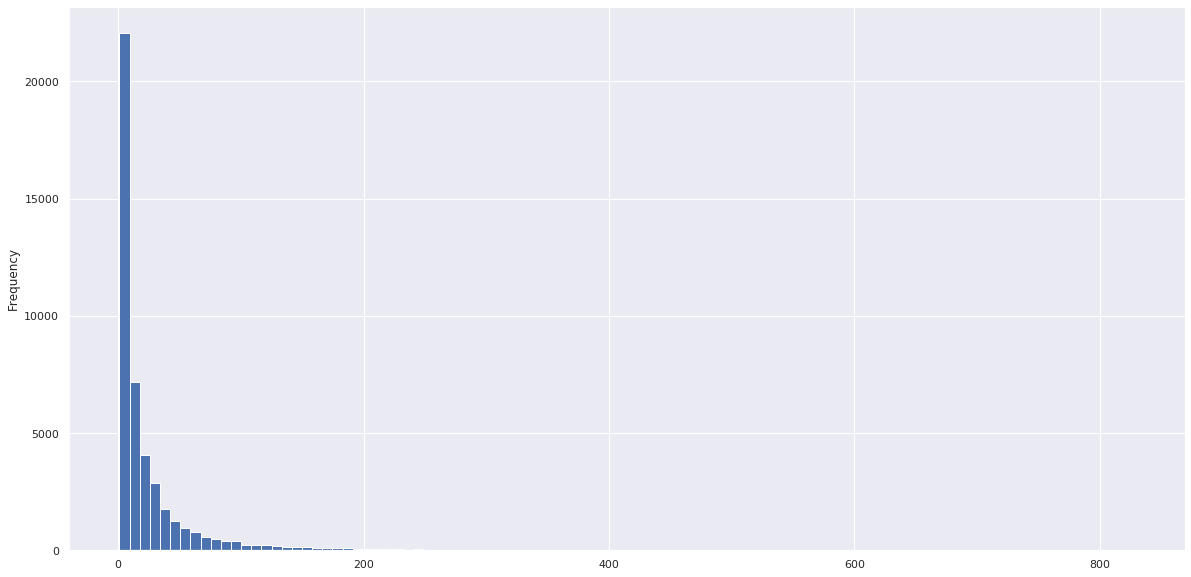

In [11]:
df2.number_of_reviews[df2.number_of_reviews!=0].plot(kind="hist" ,bins=100)

## Prédiction en régression

Toutes les variables vont être utiliser.

Nous allons effectuer une première série de regressions sur les données. Nous allons faire l'estimation du score moyen (en utilisant les données de prix hebdo) ainsi qu'une estimation du prix hebdo (en utilisant cette fois les données de prix moyen).


81.05368278013533


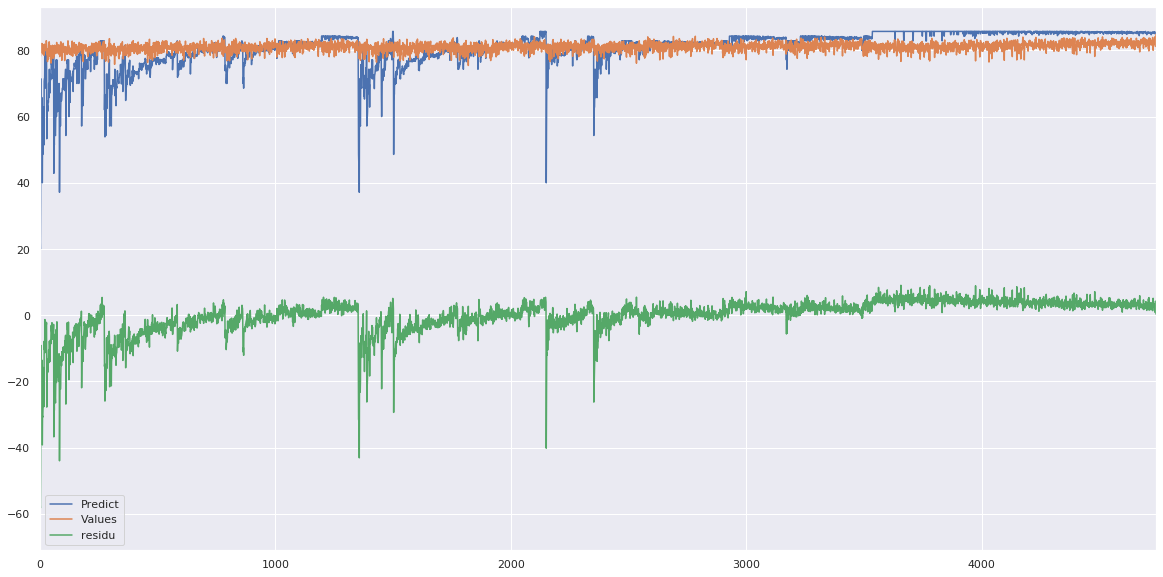

In [12]:
result = pd.read_csv("./airbnb/result.csv", delimiter=',', header=None,names=["Predict","Values"])
result["residu"] = result.Predict - result.Values
print(np.mean(result.Values))

result.plot()

619.8522492161405


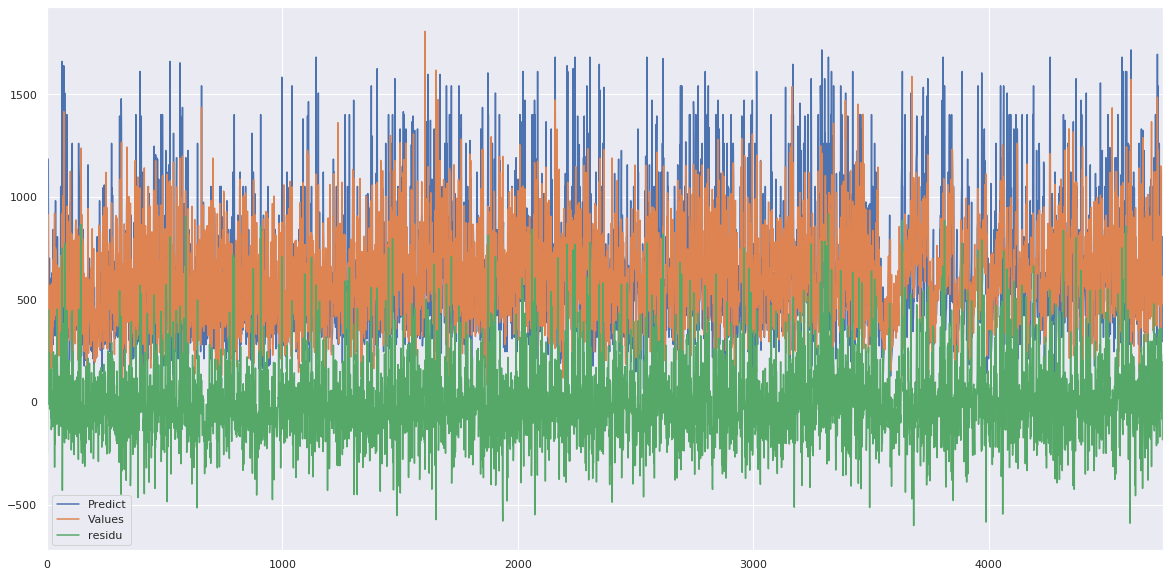

In [13]:
result = pd.read_csv("/home/martinez/git/ms2020bgd/SD701/airbnb/weekly_price.csv", delimiter=',', header=None,names=["Predict","Values"])
result["residu"] = result.Predict - result.Values
print(np.mean(result.Values))

result.plot()